### Configurable Variables
Variables that can be modified in this notebook
- `input_data` — path to the input folder containing the dataset
- `supress_warnings` — boolean flag to enable/disable warning messages (`True`/`False`)
---
**Set following variables if you are running notebook interactively.**

In [388]:
input_path_folder_default = "output_datasets/SN124_A938797_Rep2/"
suppress_warnings_default = False
grid_size_default = 21

# SPATIAL TRANSCRIPTOMICS – IDENTIFICATION OF SVGs WITH SOMDE

Spatial transcriptomics links gene expression to tissue location. To find **spatially variable genes (SVGs)**, we use **SOMDE**, a fast method that detects spatial expression patterns using **self-organizing maps** and **statistical modeling**. This notebook demonstrates how to load data, run SOMDE, and visualize the resulting SVGs.


### Load variables from CMD

In [389]:
SUPPRESS_WARNINGS = None
try:
    if suppress_warnings == "True":
        SUPPRESS_WARNINGS = True
    else:
        SUPPRESS_WARNINGS = False
except NameError:
    SUPPRESS_WARNINGS = suppress_warnings_default

try:
    GRID_SIZE = grid_size
except NameError:
    GRID_SIZE = grid_size_default

## Suppress Warnings (Optional)

* Suppress warnings for cleaner output.
* Comment out the line below if warnings are desired for debugging.

In [390]:
# Suppress warnings for cleaner output
import warnings
import os

if SUPPRESS_WARNINGS:
    print("Ignoring warnings.")
    warnings.filterwarnings('ignore')

### Environment setup

1. Install the necessary packages using `pip` if they are not already installed:

In [391]:
# use conda env from readme

2. Import necessary libraries:

In [392]:
# work with files libraries
import os
import sys
import csv

# SOMDE libraries
import somoclu
from somde import plotgene
from somde import SomNode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import math

# cpu usage and time statistics
import psutil
import time
import platform

3. load the dataset
  * **Option 1**: Import data directly from Google Drive (requires Google Colab).
  * **Option 2**: Load dataset path from CMD.

In [393]:
# OPTION 1
# from google.colab import drive
# drive.mount('/content/drive')

In [394]:
# OPTION 2
DATA_PATH = None
try:
    DATA_PATH = input_data_folder
except NameError:
    DATA_PATH = input_path_folder_default

if DATA_PATH is None or not os.path.exists(DATA_PATH):
    print("ERROR: Datapath (", DATA_PATH ,") not found.")
    sys.exit()

print("Using input path:", DATA_PATH)

DATA_FOLDER_NAME = DATA_PATH.split("/")[-2].strip()
output_dir = os.path.join("somde_results/" + DATA_FOLDER_NAME)
os.makedirs(output_dir, exist_ok=True)

os.makedirs("figures/show/somde/" + DATA_FOLDER_NAME, exist_ok=True)

Using input path: output_datasets/SN124_A938797_Rep2/


4. Get platform information

In [395]:
# ---- System info ----
cpu_model = platform.processor()
cpu_cores = psutil.cpu_count(logical=False)
cpu_threads = psutil.cpu_count(logical=True)

total_ram = psutil.virtual_memory().total / (1024**3)  # GB

print("CPU model:", cpu_model)
print("CPU cores:", cpu_cores)
print("CPU threads:", cpu_threads)
print("Total RAM: {:.2f} GB".format(total_ram))

# ---------------- SAVE TO CSV -----------------
csv_file = os.path.join(output_dir, "system_info.csv")

with open(csv_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["CPU_model", "CPU_cores", "CPU_threads", "Total_RAM_GB"])
    writer.writerow([cpu_model, cpu_cores, cpu_threads, round(total_ram, 2)])

print(f"System info saved to {csv_file}")

CPU model: i386
CPU cores: 8
CPU threads: 8
Total RAM: 24.00 GB
System info saved to somde_results/SN124_A938797_Rep2/system_info.csv


# SOMDE analaysis

### Load gene expression data
**Expecxted files**
- *Expression counts (`count.csv`)* with spots as rows and genes as columns.
- *Metadata (`idx.csv`)* containing spatial coordinates


In [396]:
# Load expression counts
df = pd.read_csv(os.path.join(DATA_PATH, "count.not_normalized.csv"), sep=',', index_col=0)
print("Counts shape:", df.shape)

# Load metadata / spot info
corinfo = pd.read_csv(os.path.join(DATA_PATH, "idx.not_normalized.csv"), sep=',', index_col=0)

# Add total counts per spot (sum across genes) with proper alignment
total_counts = df.sum(axis=1)
corinfo["total_count"] = total_counts.reindex(corinfo.index)
print(corinfo.head())

# Extract spatial coordinates
X = corinfo[['x', 'y']].values.astype(np.float32)

# Preview
print("Counts matrix shape:", df.shape)
print(df.head())
print("Spatial coordinates shape:", X.shape)
print("Metadata preview:")
print(corinfo.sort_values(by=['x', 'y'], ascending=True).head())

num_samples = X.shape[0]
print("Number of spots / samples:", num_samples)

Counts shape: (1688, 36601)
                       x     y  total_count
AAACAATCTACTAGCA-1   746   225      29697.0
AAACAGAGCGACTCCT-1  1401   472      33122.0
AAACGAAGAACATACC-1  1016   293      35719.0
AAACGAGACGGTTGAT-1  1208   941      30983.0
AAACTGCTGGCTCCAA-1  1053  1164      13279.0
Counts matrix shape: (1688, 36601)
                    MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  \
AAACAATCTACTAGCA-1          0.0      0.0    0.0         0.0         0.0   
AAACAGAGCGACTCCT-1          0.0      0.0    0.0         0.0         0.0   
AAACGAAGAACATACC-1          0.0      0.0    0.0         0.0         0.0   
AAACGAGACGGTTGAT-1          0.0      0.0    0.0         0.0         0.0   
AAACTGCTGGCTCCAA-1          0.0      0.0    0.0         0.0         0.0   

                    AL627309.2  AL627309.5  AL627309.4  AP006222.2  \
AAACAATCTACTAGCA-1         0.0         0.0         0.0         0.0   
AAACAGAGCGACTCCT-1         0.0         0.0         0.0         0.0   
AAACGAAGAACA

### Initialize SOM Node

This cell creates and trains a **Self-Organizing Map (SOM) node** using the spatial coordinate matrix `X`.

In [397]:
print("SOM node creation")

process = psutil.Process(os.getpid())
process.cpu_percent(interval=None)   # reset counters

start_cpu = time.process_time()
start_wall = time.time()

k = num_samples / (GRID_SIZE * GRID_SIZE)
# -------- code to measure -----------
som = SomNode(X, k)
print(50 * "-")
# ------------------------------------

end_cpu = time.process_time()
end_wall = time.time()

cpu_time = end_cpu - start_cpu
wall_time = end_wall - start_wall
cpu_usage = process.cpu_percent(interval=None)
ram_usage = process.memory_info().rss / (1024**2)  # MB

print("CPU time: {:.6f} seconds".format(cpu_time))
print("Wall time: {:.6f} seconds".format(wall_time))
print("CPU usage (%):", cpu_usage)
print("RAM used by process: {:.2f} MB".format(ram_usage))

# ---------------- SAVE TO CSV -----------------
with open(os.path.join(output_dir,  "requirements.csv"), "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Task", "CPU_time", "Wall_time", "CPU_usage_percent", "RAM_used_MB"])
    writer.writerow(["somde node creation", cpu_time, wall_time, cpu_usage, ram_usage])

SOM node creation
using 20*20 SOM nodes for 1688 points
--------------------------------------------------
CPU time: 0.402539 seconds
Wall time: 0.077221 seconds
CPU usage (%): 12.4
RAM used by process: 2275.64 MB


### Visualize Initial SOM Codebook

This cell visualizes the **initial codebook** of the Self-Organizing Map (SOM).

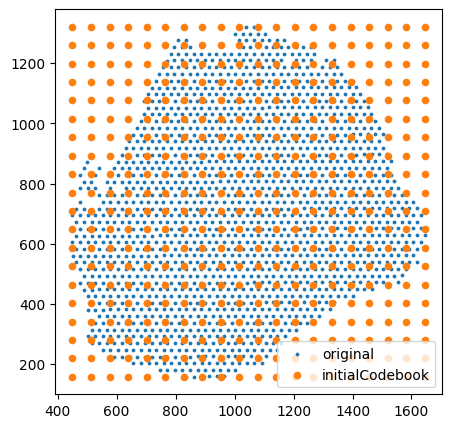

In [398]:
som.viewIniCodebook()

fig = plt.gcf()
fig.set_size_inches(5, 5)
fig.savefig(
    f"figures/show/somde/{DATA_FOLDER_NAME}/ini_codebook.png",
    dpi=300,
    bbox_inches="tight"
)

### Plot the Trained SOM

This cell visualizes the **trained Self-Organizing Map (SOM)** and the mapping of data points onto it.

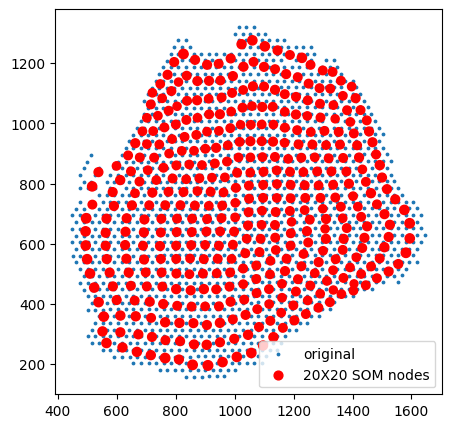

In [399]:
# Plot the SOM (creates its own figure)
som.view()

fig = plt.gcf()
fig.set_size_inches(5, 5)
fig.savefig(
    f"figures/show/somde/{DATA_FOLDER_NAME}/somde_points.png",
    dpi=300,
    bbox_inches="tight"
)

### Map Expression Data onto the SOM

This cell projects the **gene expression matrix** onto the trained SOM.

In [400]:
ndf, ninfo = som.mtx(df.T)
print(ndf.shape)
print(ninfo.shape)

ndf.to_csv('somde_results/' + DATA_FOLDER_NAME + '/ndf.csv', index=False)
print("ndf saved to " + DATA_FOLDER_NAME + "/ndf.csv")
ninfo.to_csv('somde_results/' + DATA_FOLDER_NAME + '/ninfo.csv', index=False)
print("ninfo saved to " + DATA_FOLDER_NAME + "/ninfo.csv")

genes = df.columns


(36601, 400)
(400, 3)
ndf saved to SN124_A938797_Rep2/ndf.csv
ninfo saved to SN124_A938797_Rep2/ninfo.csv


### Visualize Gene Expression on the SOM

This cell plots the spatial distribution of selected genes on the SOM.

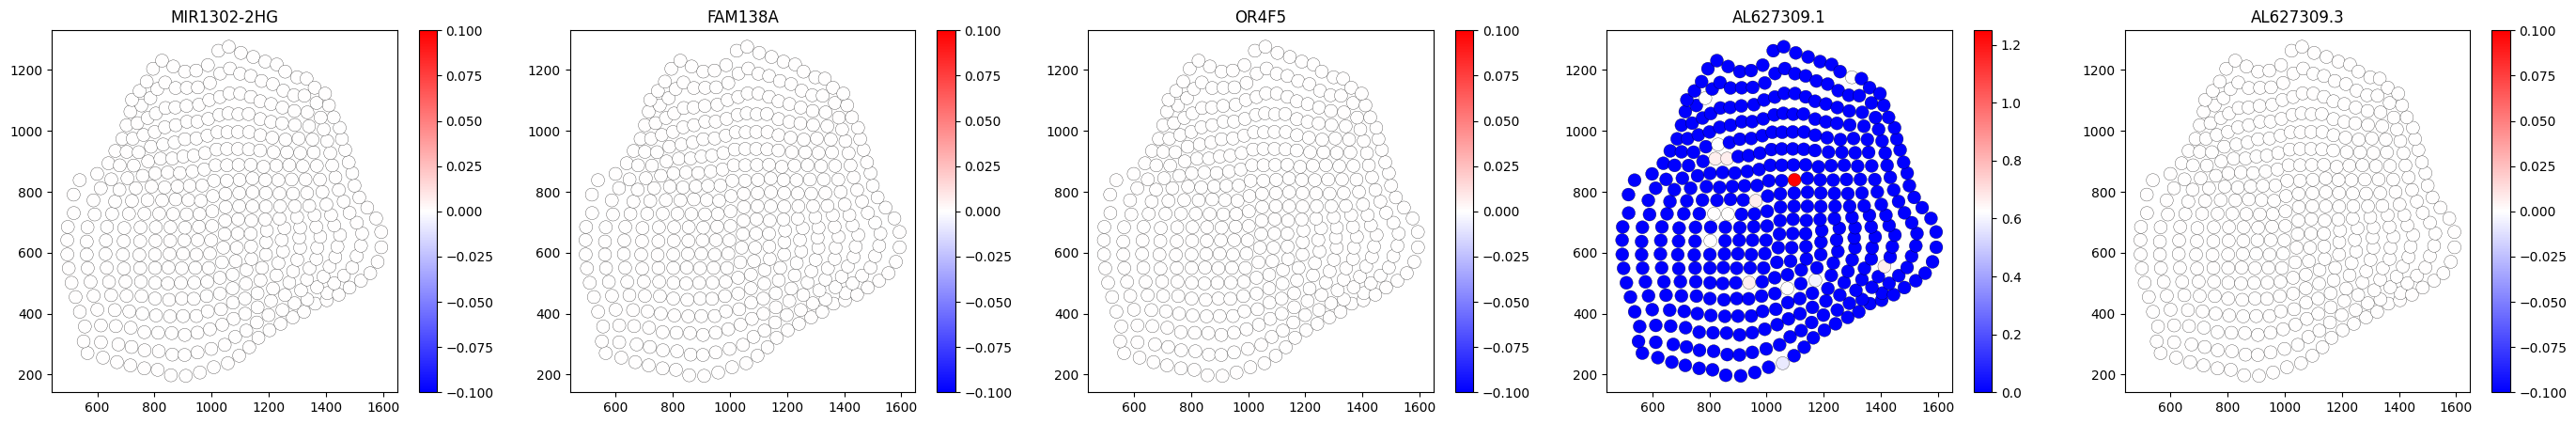

In [401]:
plotgene(
    X=ninfo.values,
    mtx=ndf,
    draw_list=genes[:5],
    result=som,
    sp=100,
    lw=0.2,
    N=10,
    plotsize=5
)

### Normalize and Run SOMDE Analysis

This cell performs **normalization** and runs the **SOMDE algorithm** on the dataset.

In [402]:
nres = som.norm()

print("SOMDE analysis")

process = psutil.Process(os.getpid())
process.cpu_percent(interval=None)   # reset counters

start_cpu = time.process_time()
start_wall = time.time()

# -------- code to measure -----------
result, SVnum =som.run()
# ------------------------------------

end_cpu = time.process_time()
end_wall = time.time()

cpu_time = end_cpu - start_cpu
wall_time = end_wall - start_wall
cpu_usage = process.cpu_percent(interval=None)
ram_usage = process.memory_info().rss / (1024**2)  # MB

print("CPU time: {:.6f} seconds".format(cpu_time))
print("Wall time: {:.6f} seconds".format(wall_time))
print("CPU usage (%):", cpu_usage)
print("RAM used by process: {:.2f} MB".format(ram_usage))

# ---------------- SAVE TO CSV -----------------
with open(os.path.join(output_dir,  "requirements.csv"), "a", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["somde analysis", cpu_time, wall_time, cpu_usage, ram_usage])

SOMDE analysis


 29%|██▉       | 10544/36601 [00:17<00:41, 630.12it/s]/Users/polakova/miniconda3/envs/myproject_x86/lib/python3.8/site-packages/somde/util.py:310: RuntimeWarning: divide by zero encountered in double_scalars
  s2_logdelta = 1. / (derivative(LL_obj, np.log(max_delta), n=2) ** 2)

 20%|██        | 7473/36601 [00:16<01:07, 431.47it/s]/Users/polakova/miniconda3/envs/myproject_x86/lib/python3.8/site-packages/somde/util.py:310: RuntimeWarning: divide by zero encountered in double_scalars
  s2_logdelta = 1. / (derivative(LL_obj, np.log(max_delta), n=2) ** 2)

  7%|▋         | 2494/36601 [00:04<00:58, 584.66it/s]/Users/polakova/miniconda3/envs/myproject_x86/lib/python3.8/site-packages/somde/util.py:310: RuntimeWarning: divide by zero encountered in double_scalars
  s2_logdelta = 1. / (derivative(LL_obj, np.log(max_delta), n=2) ** 2)

  7%|▋         | 2472/36601 [00:04<00:59, 572.30it/s]/Users/polakova/miniconda3/envs/myproject_x86/lib/python3.8/site-packages/somde/util.py:310: RuntimeWarning: 

CPU time: 4017.817193 seconds
Wall time: 631.851726 seconds
CPU usage (%): 15.3
RAM used by process: 1288.12 MB


### Visualize Spatially Variable Genes from SOMDE

This cell plots the expression patterns of selected **spatially variable genes (SVGs)**

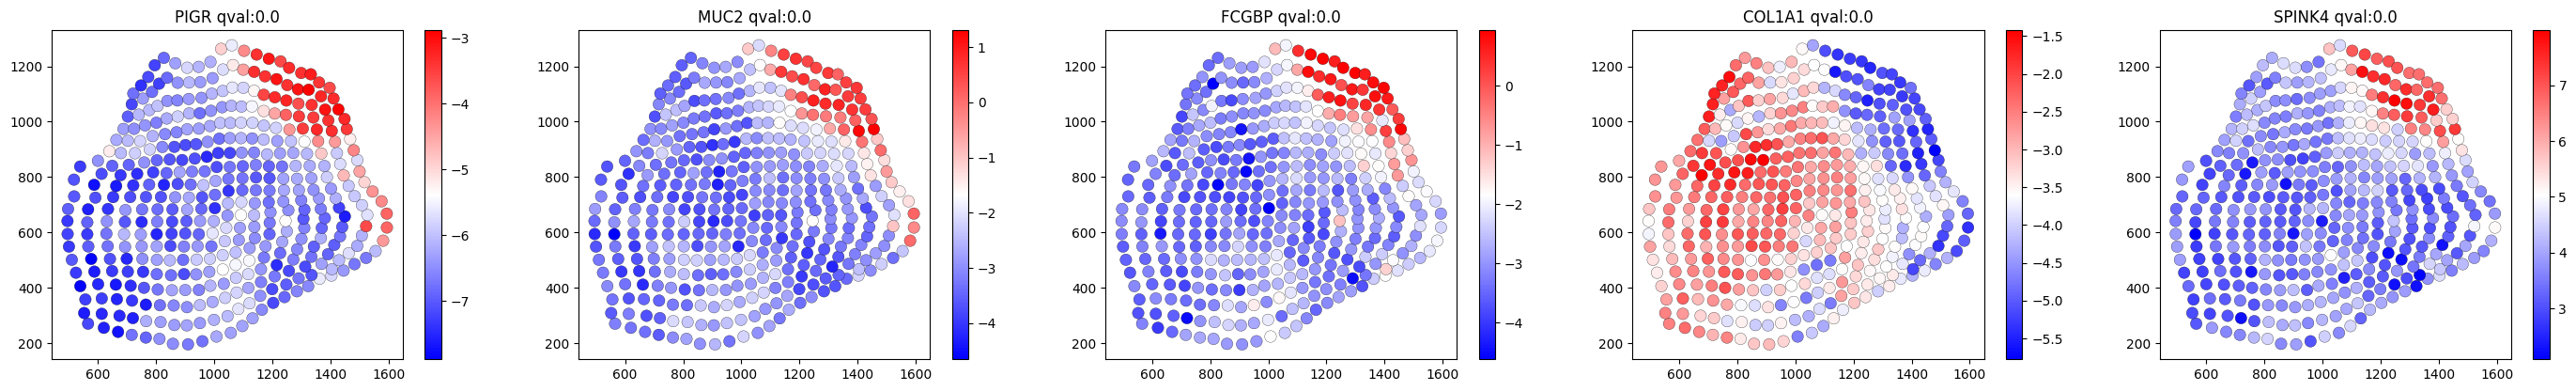

In [403]:
genes_to_display = result.g.to_list()[:5]

plotgene(ninfo[['x','y']].values,nres.T,genes_to_display,result,sp=80,lw=0.2,plotsize=5)

### Plot Selected Spatially Variable Genes on Original Coordinates

This cell visualizes the expression patterns of a subset of **spatially variable genes (SVGs)** on the **original spatial coordinates**.

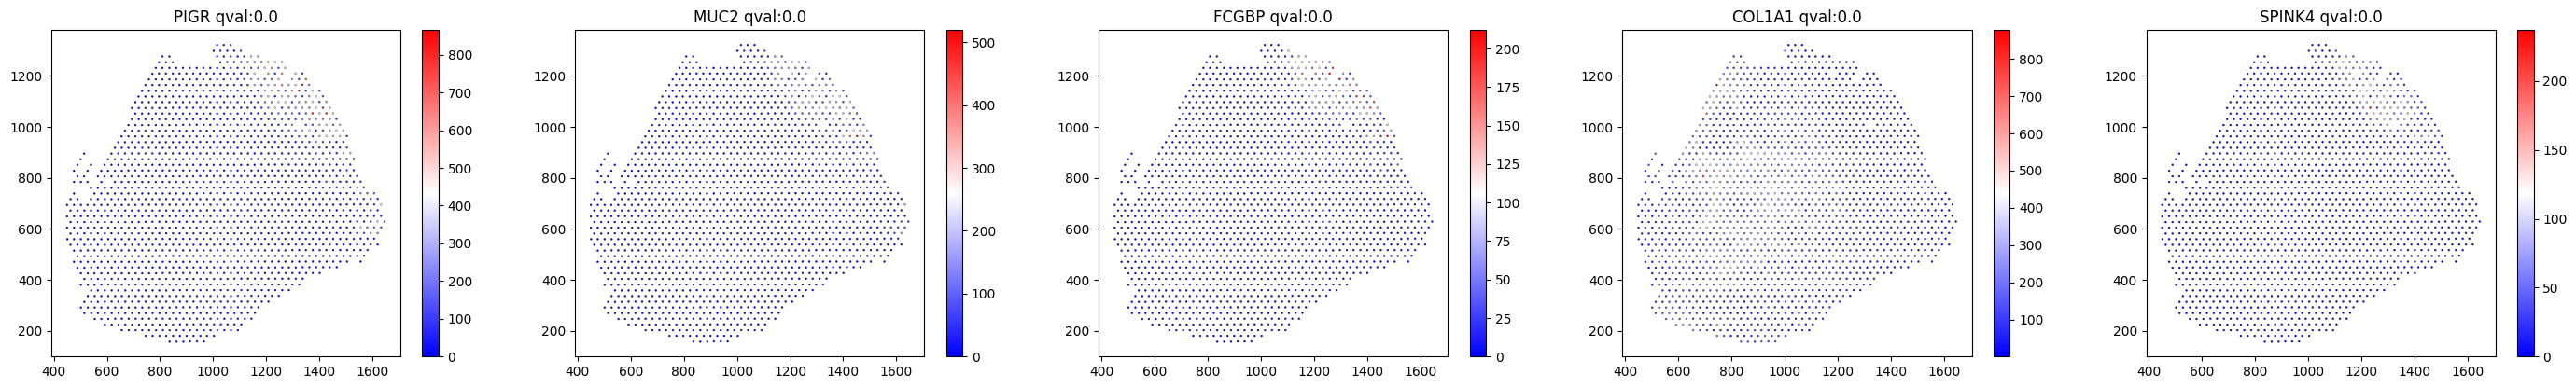

In [404]:
genes_to_display = result.g.to_list()[:5]
plotgene(corinfo[['x','y']].values,df.T,genes_to_display,result,sp=2,lw=0.2,plotsize=5)

### Display Number of Spatially Variable Genes

### Display SOMDE Results Object

This cell outputs the **full SOMDE results object**.

In [405]:
result

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval
13903,0.856434,4,PIGR,123.452344,0.153383,-261.926145,-6.155696,2.267011,SE,400,0.000048,0.002931,0.001348,547.818147,-604.118291,342.192147,0.0,0.0
22615,0.831043,4,MUC2,123.452344,0.186026,-294.187974,-2.519159,1.109377,SE,400,0.000051,0.002502,0.001228,612.341807,-634.263431,340.075457,0.0,0.0
34972,0.827381,4,FCGBP,223.133134,0.159787,-310.878269,-2.307655,1.454902,SE,400,0.000228,0.010801,0.001226,645.722397,-612.728530,301.850261,0.0,0.0
28309,0.816175,4,COL1A1,123.452344,0.206083,-277.787872,-3.424609,1.166888,SE,400,0.000096,0.004167,0.001050,579.541602,-562.371380,284.583508,0.0,0.0
33555,0.802458,4,SPINK4,223.133134,0.188536,-332.115457,4.302016,1.601786,SE,400,0.000480,0.019021,0.001234,688.196772,-611.268337,279.152880,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24744,0.926264,4,AC148477.1,123.452344,0.072839,14182.284592,-0.483930,0.008790,SE,400,0.000021,0.003690,0.002970,-28340.603325,14509.083942,-326.799350,1.0,1.0
22290,0.926264,4,AC010157.2,123.452344,0.072839,14182.284592,-0.483930,0.008790,SE,400,0.000021,0.003690,0.003097,-28340.603325,14509.083942,-326.799350,1.0,1.0
24743,0.926264,4,AC148477.4,123.452344,0.072839,14182.284592,-0.483930,0.008790,SE,400,0.000021,0.003690,0.002988,-28340.603325,14509.083942,-326.799350,1.0,1.0
27291,0.926264,4,MT4,123.452344,0.072839,14182.284592,-0.483930,0.008790,SE,400,0.000021,0.003690,0.003033,-28340.603325,14509.083942,-326.799350,1.0,1.0


In [406]:
result.to_csv(os.path.join(output_dir,  "somde_result.csv"), index=True)

### Spatially variable genes
Somde consider gene as spatially variable if **qval <= 0.05**.

In [407]:
SV_genes = result[(result['qval'] <= 0.05)]

print(len(SV_genes["g"].to_list()), SVnum)

5276 5276


In [408]:
print(SVnum)

with open(os.path.join(output_dir,"SVnum.csv"), "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["SVnum"])
    writer.writerow([SVnum])

5276
